In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import random
from sklearn.manifold import MDS
from scipy.spatial.distance import jaccard, cosine, euclidean, correlation, cityblock
from scipy.sparse import random

import keras
from keras import layers

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import plotly.express as px
from plotly.offline import init_notebook_mode
from sklearn.metrics import pairwise_distances
from sklearn.metrics import euclidean_distances


import plotly.io as pio
pio.renderers.default = "notebook_connected"

init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

# Problema de investigación: Clustering en extrema alta dimensionalidad
Como no se puede hacer clustering directo sobre un promedio de XXXX dimensiones para agrupar a los países por sector es necesario realizar previamente una reducción de la dimensionalidad.

Algunas de las herramientas existentes para la reducción de dimensionalidad:
* PCA
* t-SNE
* UMAP

Sus límites implican buscar alternativas que puedan enfrentar eficientemente el problema, tanto desde el punto de vista de la  exactitud de sus resultados (dificil de evaluar en una clasificación no supervisada) como desde el punto de vista computacional (que pueda ejecutarse y obtener resultados en un tiempo prudencial).

Una aproximación posible a este problema es la utilización de Autoencoders, redes neuronales cuyo propósito es la reducción de la dimensionalidad abstrayendo atributos de datos complejos a través de diferentes capas de procesamiento.

In [3]:
raw_data = pd.read_csv(r"C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\BACI_HS17_Y2019_V202301.csv")
codigos = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\country_codes_V202301.csv')
GDP_L = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\GDP_L.csv')
region = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\region.csv')
population = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\population.csv')

ncm_ciiu = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\hs5_isic3.csv',
                                                    dtype={"HS5_6d":str,
                                                          "HS5_4d":str,
                                                          "HS5_2d":str,
                                                          "ISIC3_4d":str,
                                                          "ISIC3_3d":str,
                                                          "ISIC3_2d":str,
                                                          "ISIC3_1d":str})

In [4]:
raw_data.rename(columns={"k": "hs17_6d", "i": "x", "j": "m"}, inplace=True)
raw_data.drop(columns=["t", "m", "q"], inplace=True)
raw_data['hs17_6d'] = raw_data['hs17_6d'].astype(str)
raw_data['hs17_6d'] = raw_data['hs17_6d'].apply(lambda x: x.zfill(6) if len(x) == 5 else x)
raw_data = raw_data.groupby(['x','hs17_6d'], as_index=False)['v'].sum()

#raw_data["hs17_2d"] = raw_data['hs17_6d'].str[:2]

raw_data = raw_data.merge(codigos[["iso_3digit_alpha", 'country_code']], left_on='x', right_on='country_code',
                          how='left').drop(columns=['country_code', 'x']).rename(columns={"iso_3digit_alpha": "x"})

raw_data = pd.merge(raw_data, ncm_ciiu[['HS5_6d','ISIC3_2d']], left_on="hs17_6d", right_on="HS5_6d", how="left").drop(columns="HS5_6d").dropna()

In [5]:

raw_data = pd.merge(raw_data, population[['Country Code','2019']], left_on="x", right_on="Country Code", how="left").rename(columns={'2019': 'population'})

raw_data= raw_data[raw_data.population>1000000]



In [6]:
raw_data = raw_data.drop(columns='population')

In [7]:
raw_data["v_rel"] = raw_data['v'] / raw_data.groupby(['x', 'ISIC3_2d'])['v'].transform('sum')


## Grafo

In [9]:

# distancia = pairwise_distances(sector_binary.values, metric='jaccard')
#
# distancia[np.triu_indices(distancia.shape[0], k=0)] = np.nan
# distancia = pd.DataFrame(distancia, index=sector.index, columns=sector.index)
# distancia = distancia.unstack()
# distancia.index.names = ['c1', 'c2']
# distancia = distancia.reset_index().rename(columns={0: 'inv_weight'})
# data_network = distancia[pd.notna(distancia.inv_weight)]
# data_network['weight'] = 1-data_network.inv_weight
#
#
# data_network[['c1', 'c2', 'weight']]

In [10]:
# import networkx as nx
# plt.figure(figsize=(15,15))
#
# G = nx.from_pandas_edgelist(data_network, 'c1', 'c2', edge_attr=['weight'])
#
# T = nx.minimum_spanning_tree(G, weight='inv_weight')
#
# threshold = 0
# for node in G.nodes():
#     if G.degree(node) > threshold:
#         T.add_node(node)
#
# pos = nx.spring_layout(T)
#
# nx.draw_networkx(G,
#                  pos,
#                  with_labels=True, node_size=100)
#
#
# plt.show()

In [11]:
# communities = nx.community.louvain_communities(T, seed=46)

In [12]:
# num_communities = len(communities)
# num_communities

In [13]:
# communities

In [14]:
# node_community_dict = {}
# for community_id, community in enumerate(communities):
#     for node in community:
#         node_community_dict[node] = community_id

In [15]:
# color_map = plt.get_cmap('tab20', num_communities)
#
# # Step 5: Create a list of colors for each node based on their community assignment
# node_colors = [color_map(node_community_dict[node]) for node in G.nodes()]
#


otro intento

In [16]:
def recorte_sectorial(ciiu, raw_data=raw_data):
    data = raw_data.copy()
    sector = data[data.ISIC3_2d==ciiu]
    sector = pd.pivot_table(sector, index='x', columns='hs17_6d', values='v_rel').fillna(0)
    sector_binary = pd.DataFrame(np.where(sector>0.01, 1, 0), index=sector.index, columns=sector.columns)
    return sector_binary

In [17]:
def distancia(sector_binary):
    distancia= pairwise_distances(sector_binary.values, metric='jaccard')
    dist_matrix = pd.DataFrame(distancia, index=sector_binary.index, columns=sector_binary.index)
    return dist_matrix


In [68]:


def dimensionality_reduction(dist_matrix,ciiu):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, metric=True)
    embedding = mds.fit_transform(dist_matrix)
    #print(f"absolut stress: {mds.stress_}")
    dissimilarity_matrix_reconstructed = euclidean_distances(embedding, embedding)
    dissimilarity_matrix_reconstructed[np.triu_indices(dissimilarity_matrix_reconstructed.shape[0], k=1)] = np.nan

    np_dist_matrix = np.array(dist_matrix)
    np_dist_matrix[np.triu_indices(np_dist_matrix.shape[0], k=1)] = np.nan

    errores = (np_dist_matrix - dissimilarity_matrix_reconstructed).flatten()
    errores = errores[~np.isnan(errores)]

    sns.histplot(errores, bins=10)
    plt.axvline(np.mean(errores), color='red')
    plt.axvline(np.median(errores), color='green')
    #plt.show()

    numerador= np.nansum((np_dist_matrix - dissimilarity_matrix_reconstructed)**2)

    #denominador = np.nansum(dissimilarity_matrix_reconstructed**2) # se usa para normalizar el stress en NMDS (ordinal)
    denominador=np_dist_matrix.copy()
    denominador[np.tril_indices(denominador.shape[0], k=1)] = 1
    denominador = np.nansum(denominador)

    mean_stress = numerador/denominador
    print(f"mean stress: {mean_stress}")

    # pd.DataFrame(embedding).plot.scatter(x=0, y=1, title=ciiu)
    # plt.show()
    return embedding

In [72]:
def k_means(new_coord):
    k_range = range(2, 11)

    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123).fit(new_coord)
        labels = kmeans.labels_
        score = silhouette_score(new_coord, labels)
        silhouette_scores.append(score)

    # Plot the average silhouette score for each value of k
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average silhouette score')
    #plt.show()

    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

    kmeans = KMeans(n_clusters=optimal_k)
    clusters = kmeans.fit_predict(new_coord)
    return clusters

In [70]:

def plot_clusters(new_coord, clusters):#, sector_xx_pivot):

    sns.scatterplot(data=new_coord,
                 x=new_coord[:, 0],
                 y=new_coord[:, 1],
                 hue=clusters,
                 palette="YlGnBu",
                   )

    return

mean stress: 0.12499148791304299


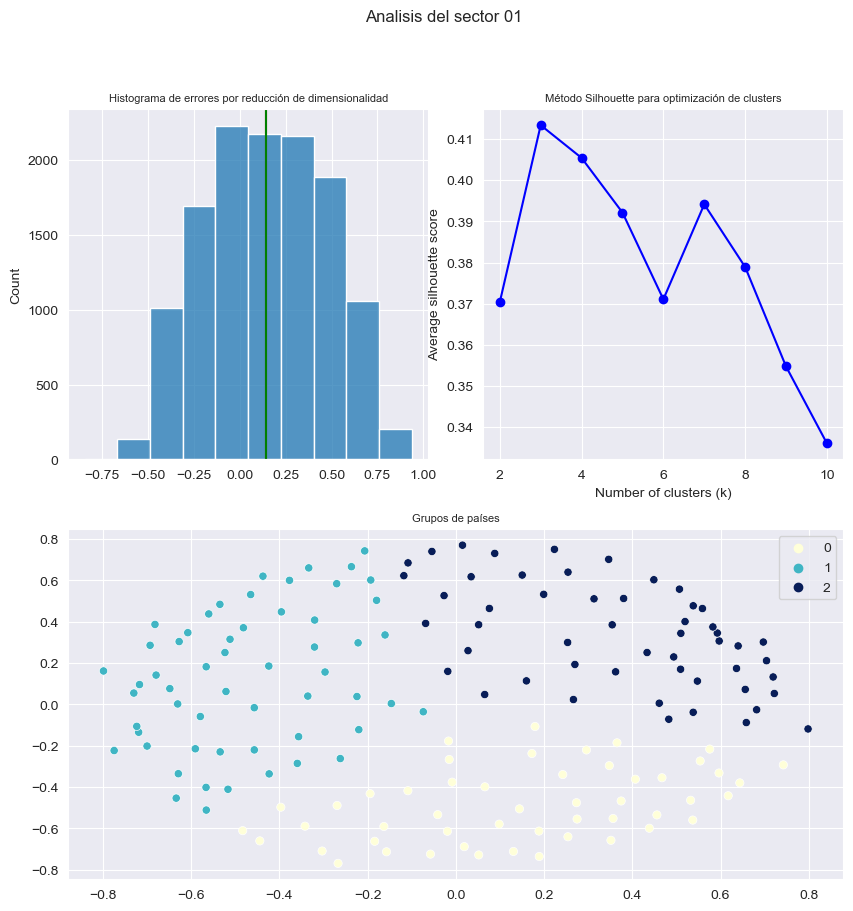

mean stress: 0.07801014176441586


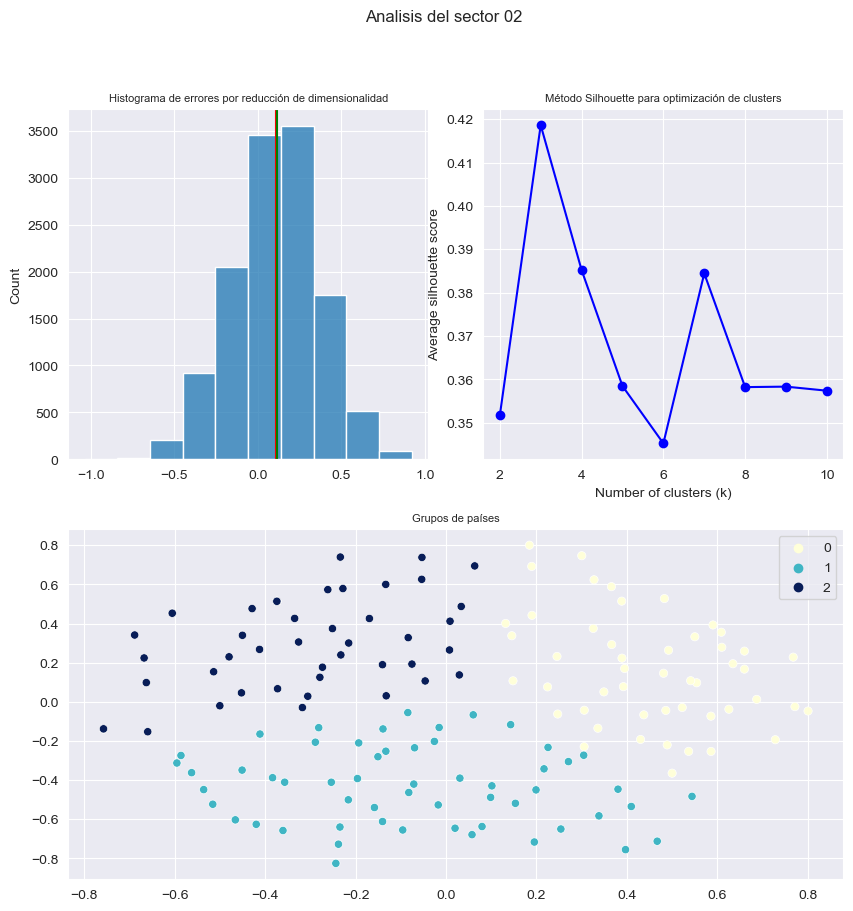

mean stress: 0.11098902718682996


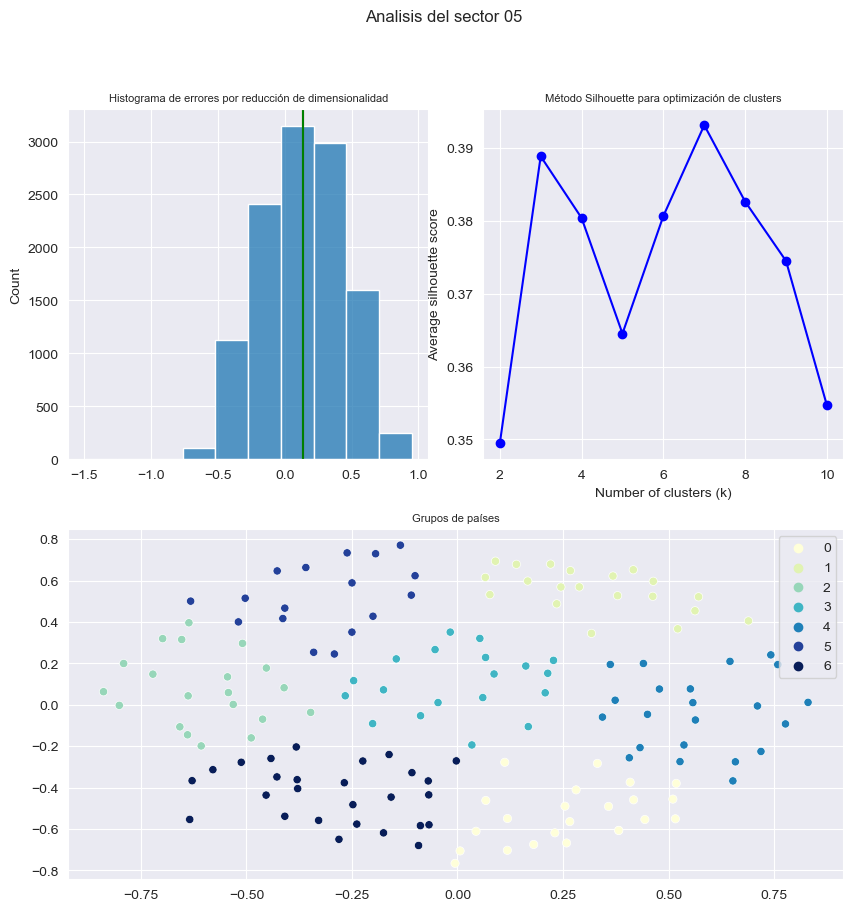

mean stress: 0.029374772257567284


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


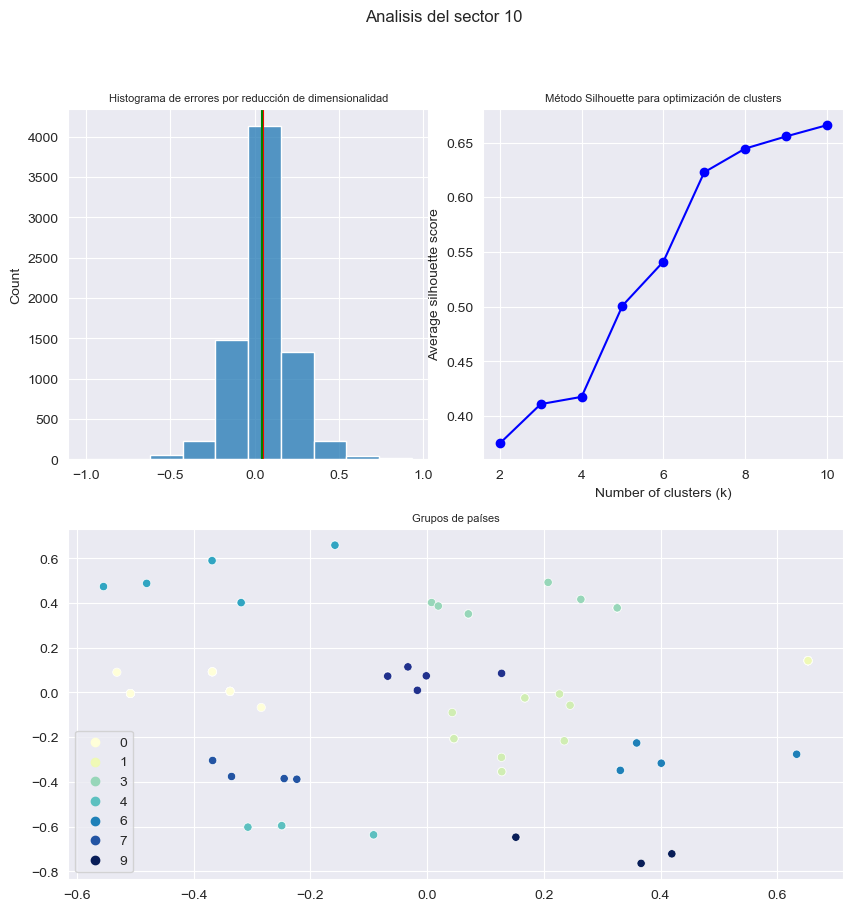

mean stress: 0.004288365699252868


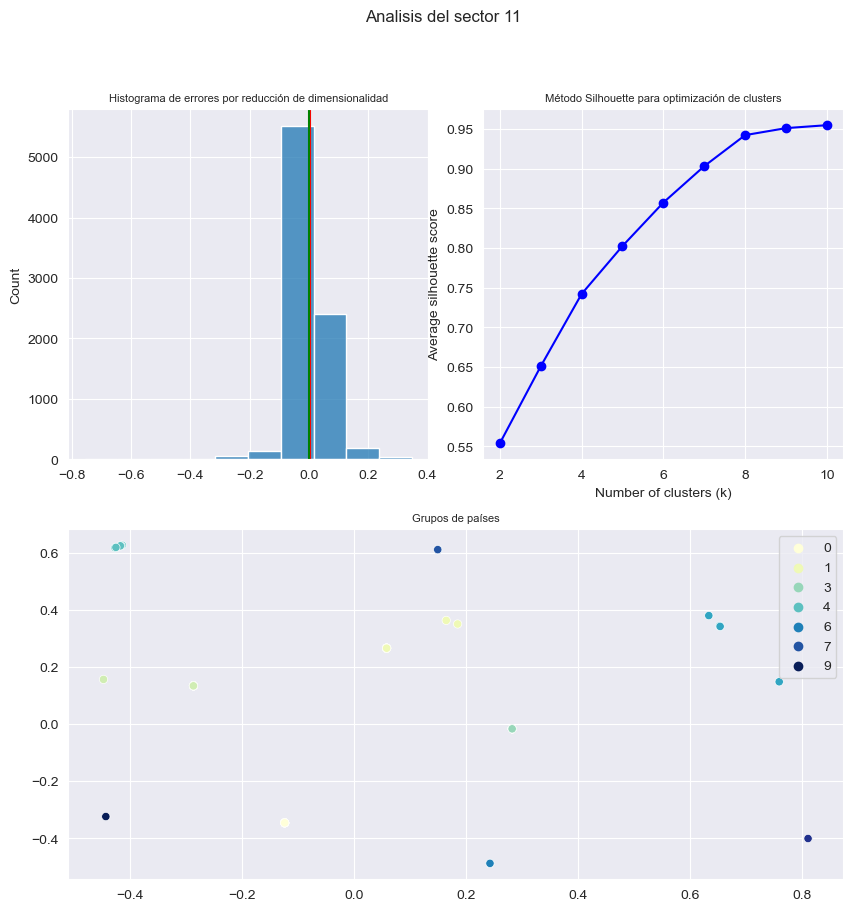

mean stress: 2.1120066946756096e-05


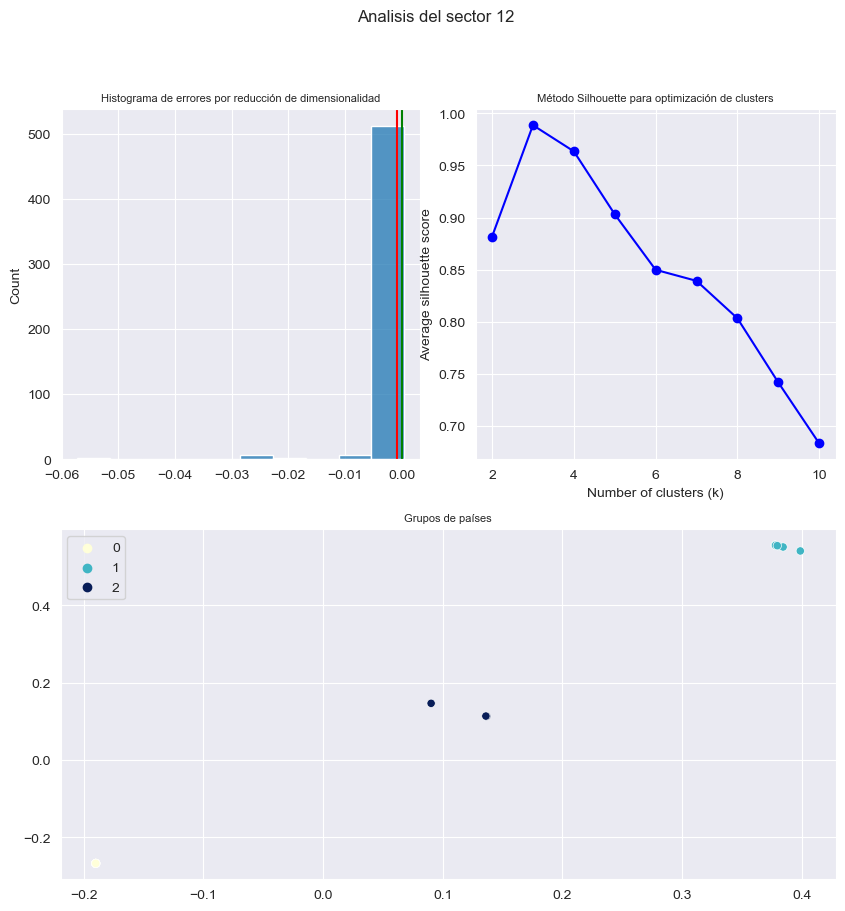

mean stress: 0.09116199589664087


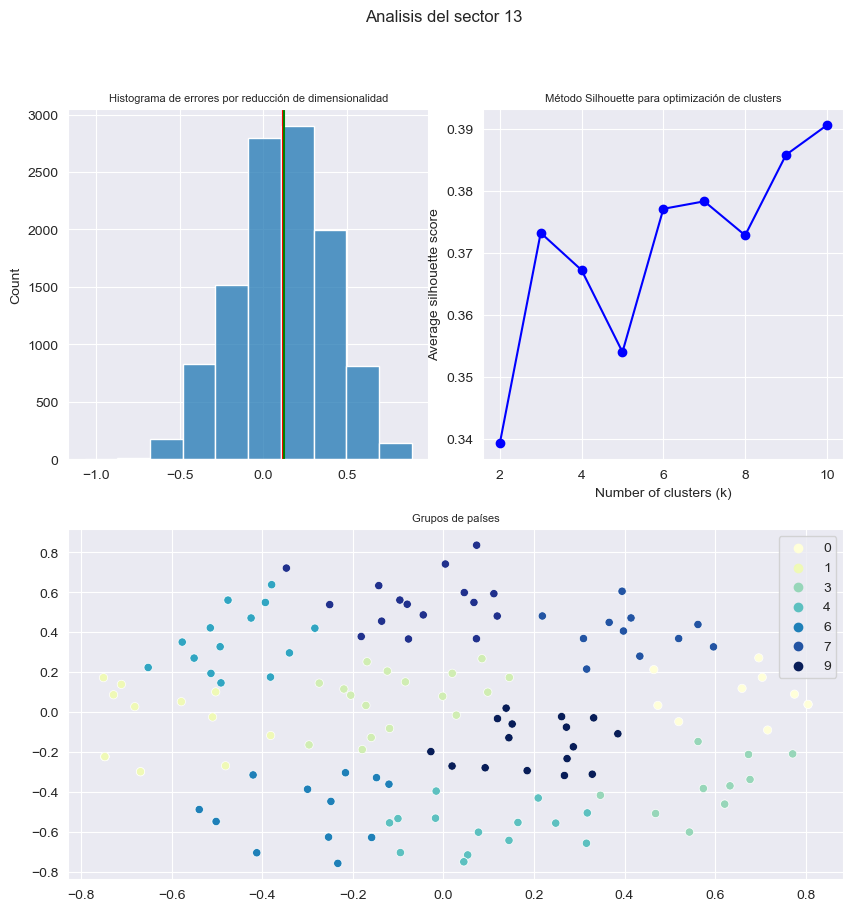

mean stress: 0.10641860414076387


KeyboardInterrupt: 

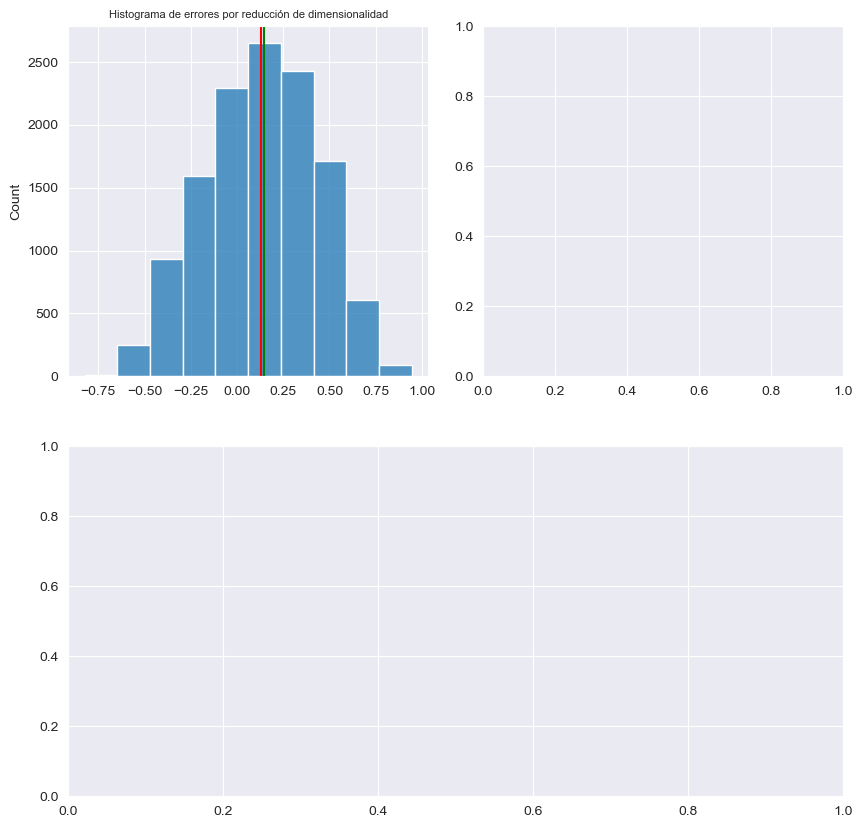

In [91]:
sectores=sorted(list(raw_data.ISIC3_2d.drop_duplicates()))[:30]


for ciiu in sectores:
    #layout
    plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 10)
    gs.update(wspace=2)
    ax1 = plt.subplot(gs[0, :5], )
    ax2 = plt.subplot(gs[0, 5:])
    ax3 = plt.subplot(gs[1, :])

    #recorte sector
    sector_binary = recorte_sectorial(ciiu)

    #calculo distancia
    dist_matrix = distancia(sector_binary)

    #reducción de dimensionalidad
    plt.sca(ax1)
    embedding = dimensionality_reduction(dist_matrix, ciiu)
    plt.title('Histograma de errores por reducción de dimensionalidad', fontsize=8)
    #clusters
    plt.sca(ax2)
    clusters = k_means(embedding)
    plt.title('Método Silhouette para optimización de clusters', fontsize=8)
    #plot
    plt.sca(ax3)
    plot_clusters(embedding, clusters)
    plt.title(f'Grupos de países', fontsize=8)

    plt.suptitle(f'Analisis del sector {ciiu}')
    plt.tight_layout()
    plt.show()

NameError: name 'new_coord' is not defined

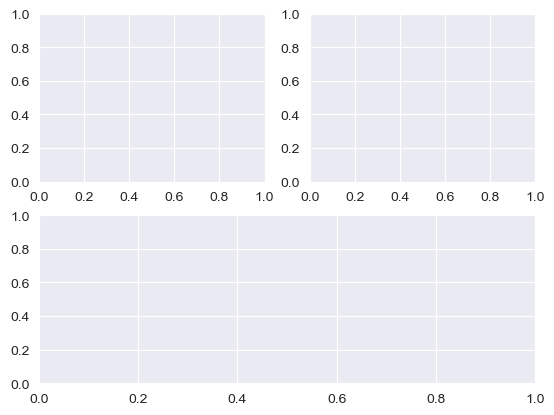

In [59]:
import matplotlib.gridspec as gridspec



plt.show()


